In [124]:
import pandas as pd
import numpy as np
from random import sample
import scipy
import statsmodels
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл: 

* LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
* default - индикатор невозврата денежных средств

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MPTI_ML_4course/week_4/credit_card_default_analysis.csv', sep=',', header=0)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
print(df.shape)

(30000, 25)


In [14]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def calculate_median_confidence_interval(data, samples_count = 1000, alpha = 0.05):
    median = np.median(data)
    medians = list(map(lambda samples_group: np.median(samples_group), get_bootstrap_samples(data, samples_count)))
    confint = stat_intervals(medians, alpha)
    return (median, confint)

def compare_distributions(data1, data2, samples_count, alpha):
    boot_med_data1 = np.asarray(list(
        map(lambda samples_group: np.median(samples_group), get_bootstrap_samples(data1, samples_count))))
    
    boot_med_data2 = np.asarray(list(
        map(lambda samples_group: np.median(samples_group), get_bootstrap_samples(data2, samples_count))))

    median_deltas = boot_med_data1 - boot_med_data2

    return stat_intervals(median_deltas, alpha)

#Задание 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   

##a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  

In [6]:
# Разделим данные на две группы default и success
df_default = df[df['default'] == 1]
df_success = df[df['default'] == 0]

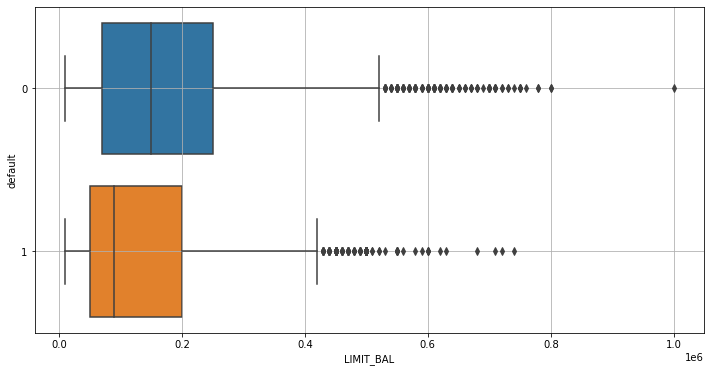

In [7]:
_, ax = plt.subplots(figsize = (12, 6), facecolor='w')
sns.boxplot(y='default', x='LIMIT_BAL', data=df, orient="h", ax=ax)
ax.grid()

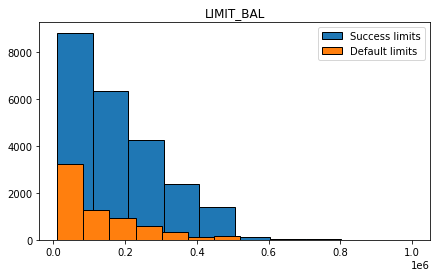

In [175]:
_, ax = plt.subplots(figsize = (7, 4), facecolor='w')
df_success.hist(column='LIMIT_BAL', label='Success limits', ax=ax, ec='k')
df_default.hist(column='LIMIT_BAL', label='Default limits', ax=ax, ec='k')
ax.legend()
ax.grid(False)
plt.show()

По графикам видно, что распределения лимитов для групп 'success' и 'default' очень похожи друг на друга, но есть разница между размерами кредитного лимита. Для группы success размер кредитного лимита выше. 

Докажем, с помощью доверительных интервалов, построенных с помощью метода bootstrap, что различие между значениями в этих группах действительно есть.


In [19]:
samples_count = 1000
alpha = 0.05
# confint for default data median
med_default_confint = calculate_median_confidence_interval(df_default['LIMIT_BAL'].values, 
                                                           samples_count, alpha)
# confint for success data median
med_success_confint = calculate_median_confidence_interval(df_success['LIMIT_BAL'].values, 
                                                             samples_count, alpha)
# confint for difference midle default and success data median
med_delta_confint = compare_distributions(df_success['LIMIT_BAL'].values, 
                                             df_default['LIMIT_BAL'].values, 
                                             samples_count, alpha)

In [179]:
print('median for default ages: %.4f\tconf_int: %s' % med_default_confint)
print('median for success ages: %.4f\tconf_int: %s' % med_success_confint)
print('conf_int for difference between default & success groups is %s' % med_delta_confint)

median for default ages: 90000.0000	conf_int: [80000. 90000.]
median for success ages: 150000.0000	conf_int: [150000. 150000.]
conf_int for difference between default & success groups is [60000. 70000.]


Доверительный интервал для разницы кредитного лимита между 'success' и 'default' группами далеко отстоит от нуля. Поэтому можно с уверенностью сказать, что кредитный лимит в группе 'success' значимо выше.

##b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения?

In [85]:
def permutation_t_stat_ind(sample1, sample2):
    return np.median(sample1) - np.median(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations is not None:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample1, sample2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [87]:
perm_results = permutation_test(df_default['LIMIT_BAL'].values, 
                                df_success['LIMIT_BAL'].values, 
                                max_permutations=1000, alternative='two-sided')
print('Permutation criterion p-value: %.4f' % perm_results)

Permutation criterion p-value: 0.0000


Доверительные интервалы для медиан в группах 'success' и 'default' сильно различаются. Эти выводы сделаны на основании следующих фактах:

-- доверительный интервал для разницы медианных значений в этих группах далеко отстоит от нуля.

-- перестановочный критерий для двух независимых выборок дает достигаемый уровень значимости сильно меньше 0.05. 

Из этого можно сделать вывод, что гипотеза о равенстве распределений отвергается. С практической точки зрения эти результаты говорят о том, что банк выдает большие кредиты надежным клиентам не просрачивающим выплаты.


#Задание 2

Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [88]:
# members of both sexes who have defaulted on a loan
default_gender = df_default['SEX'].values
# members of both sexes who have success on a loan
success_gender = df_success['SEX'].values

Применим Z-критерий для разности

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [126]:
def proportions_confint_diff(first_vector, second_vector, alpha = 0.05):
    count1 = float(len(first_vector))
    count2 = float(len(second_vector))
    p1 = float(len(list(filter(lambda x: x == 1, first_vector))))/count1
    p2 = float(len(list(filter(lambda x: x == 1, second_vector))))/count2
    z = stats.norm.ppf(1. - alpha / 2.)

    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1. - p1)/ count1 + p2 * (1 - p2)/ count2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1. - p1)/ count1 + p2 * (1 - p2)/ count2)
    
    return (left_boundary, right_boundary)

In [122]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(len(list(filter(lambda x: x == 1, sample1)))) / n1
    p2 = float(len(list(filter(lambda x: x == 1, sample2)))) / n2 
    P = float(p1 * n1 + p2 * n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(sample1, sample2, alternative = 'two-sided'):
    z_stat = proportions_diff_z_stat_ind(sample1, sample2)
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [164]:
# Function that builds a bar chart for the conjugacy matrix
def barPlot_contingency(contingency_matrix, row_groups, column_groups, ax):
    for row_index, row_name in enumerate(row_groups):
        column_counts = list(map(lambda cell: float(cell), contingency_matrix[row_index]))
        overall_count = sum(column_counts)
        if overall_count > 0:
            for column_count, column_name in zip(column_counts, column_groups):
                ax.bar(row_index, column_count / overall_count, 
                        label = '%s %s, num = %.0f' % (row_name, column_name, column_count), ec='k')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [113]:
# let's see 0 'LIMIT_BAL' for both gender
gender_contingency_table = pd.pivot_table(df[['SEX', 'default', 'LIMIT_BAL']],
                                          values=['LIMIT_BAL'],
                                          index=['SEX'],
                                          columns=['default'],
                                          fill_value = 0,
                                          aggfunc='count')
gender_contingency_matrix = gender_contingency_table.values
gender_contingency_table

LIMIT_BAL      
default         0     1
SEX                    
1            9015  2873
2           14349  3763

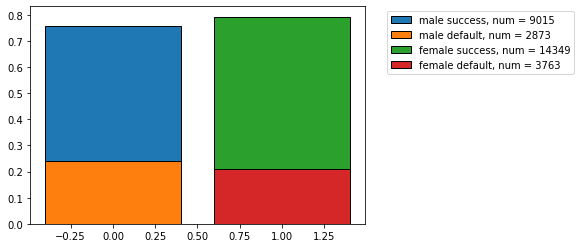

In [151]:
_, ax = plt.subplots(facecolor='w')
barPlot_contingency(gender_contingency_matrix, ['male', 'female'], ['success', 'default'], ax)

In [125]:
print('Proportion confidential interval is [%.4f; %.4f]' % proportions_confint_diff(default_gender, success_gender))

Proportion confidential interval is [0.0336; 0.0605]


При визульном рассмотрении было видно, что доля мужчин вернувших кредит ('SEX'=1) меньше доли женщин вернувших кредит ('SEX'=2). Однако такой эффект может объясняться просто большим количеством женских кредитов.

Для того, чтобы формально выяснить существует ли стат. значимые различия в двух мужских группах, которые вернули и невернули кредит, были построены дов. интервалы для разности. Оказалось, что дов. интервал не содержит 0 и находится от него справа, поэтому можно утверждать, что доля мужчин не вернувших кредит больше, чем доля вернувших.

Чтобы проверить данный результат сравним доли мужчин в тех-же группах на основе z-критерия для двух независимых выборок

In [127]:
pval = proportions_diff_z_test(default_gender, success_gender, alternative='two-sided')
pval

4.472866521609831e-12

Достигаемый уровень значимости Z-критерия p-value для этих двух выборок сильно меньше 0.05. Нулевая ипотеза о равенстве доли мужчин в группах 'default' и 'success' отвергается.

По значениям доверительного итервала можно сказать, что мужчины возвращают кредит реже, чем женщины. Доверительный интервал не сильно далек от нуля. В полне может оказаться, что существуют более значимые с практической точки зрения признаки, чем разница в гендере.

#Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

In [128]:
edu_success = df_success['EDUCATION'].values
edu_default = df_default['EDUCATION'].values

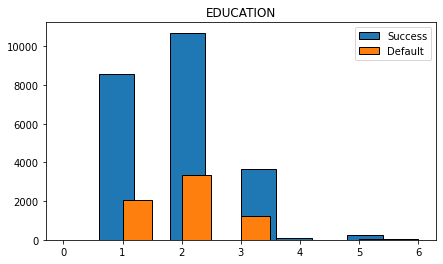

In [141]:
_, ax = plt.subplots(figsize = (7, 4), facecolor='w')
df_success.hist(column='EDUCATION', label='Success', ax=ax, ec='k')
df_default.hist(column='EDUCATION', label='Default', ax=ax, ec='k')
ax.legend()
ax.grid(False)
plt.show()

Визуально несложно заметить, что данные в группах немасштабированы. Также непонятно как можно проинтерпретировать разницу между ожидаемыми и наблюдаемыми значениях количества человек вернувших и не вернувших долг. 

In [159]:
def v_Cramer_correlation(data):
    chi_stat, pval = stats.chi2_contingency(data)[:2]
    k_min = np.min(data.shape)
    n = np.sum(data)
    return np.sqrt(chi_stat / (n * (k_min - 1))), pval

In [143]:
# let's build a conjugacy table
edu_contingency_table = pd.pivot_table(df[['EDUCATION', 'default', 'LIMIT_BAL']],
                                        values=['LIMIT_BAL'],
                                        index=['EDUCATION'],
                                        columns=['default'],
                                        fill_value = 0,
                                        aggfunc='count')
edu_contingency_matrix = edu_contingency_table.values

In [144]:
edu_contingency_table

LIMIT_BAL      
default           0     1
EDUCATION                
0                14     0
1              8549  2036
2             10700  3330
3              3680  1237
4               116     7
5               262    18
6                43     8

Представим эту матрицу сопряженности bar chart. На данном графике будут наглядно представлены доли клиентов вернувших кредит и доли клиентов просрочивших выплаты. 

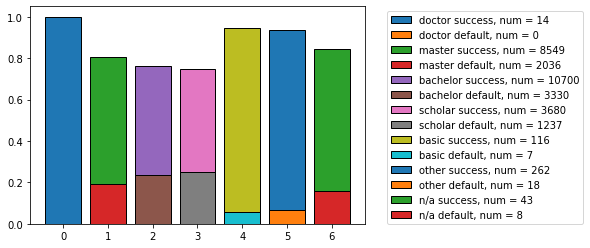

In [152]:
_, ax = plt.subplots(facecolor='w')
barPlot_contingency(edu_contingency_matrix,
                    ['doctor','master','bachelor','scholar','basic','other','n/a'], 
                    ['success', 'default'], ax)

На основании полученного графика чаще всего отдают долг люди с докторской степенью, реже всего, - люди со школьным образованием.

Т.к. признаки 'EDUCATION' и 'default' являются категориальными, то в качестве меры корреляции между ними можно использовать коэффициент V-Крамера. 

Чтобы статистически проверить наличие взаимосвязи используем критерий Хи-квадрат. Для того, чтобы применить этот критерий необходимо проверить два условия:

1) количество элементов должно быть больше 40

2) кол-во элементов больше 5 должно составлять более 80%

In [156]:
edu_contingency_matrix_to_vec = edu_contingency_matrix.reshape(-1)
count_is_enough = len(list(filter(lambda val: val > 5, edu_contingency_matrix_to_vec)))
all_to_vec_count = len(edu_contingency_matrix_to_vec)
elements_count = sum(edu_contingency_matrix_to_vec)
print('Общее количество элементов: %i.\nПроцент ячеек, где количество элементов больше 5: %.4f%%' % 
      (elements_count, (float(count_is_enough) * 100 / all_to_vec_count)))

Общее количество элементов: 30000.
Процент ячеек, где количество элементов больше 5: 92.8571%


Видно, что критерий хи-квадрат применим.

In [160]:
stat_val, p_val = v_Cramer_correlation(edu_contingency_matrix)
print('V-Cramer statistic is: %.4f' % stat_val)
print('p-value:', p_val)

V-Cramer statistic is: 0.0738
p-value: 1.2332626245415605e-32


Получили, что достигаемый уровень p-value критерия хи-квадрат сильно меньше порога значимости, поэтому мы отвергаем нулевую гипотезу (об отсутсвии взаимосвязи). Однако значение статистики V-Крамера невелико, поэтому ничего сказать о силе взаимосвязи.

# Задание 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.


Т.к. признак 'MARRIAGE' также является категориальным, то в качестве критерия можно воспользоваться критерием Хи-квадрат для статистики V-Крамера.

In [162]:
marriage_contingency_table = pd.pivot_table(df[['MARRIAGE', 'default', 'LIMIT_BAL']],
                                            values=['LIMIT_BAL'],
                                            index=['MARRIAGE'],
                                            columns=['default'],
                                            fill_value = 0,
                                            aggfunc='count')
marriage_contingency_matrix = marriage_contingency_table.values
marriage_contingency_table

LIMIT_BAL      
default          0     1
MARRIAGE                
0               49     5
1            10453  3206
2            12623  3341
3              239    84

Bar chart для данной таблице представлен ниже

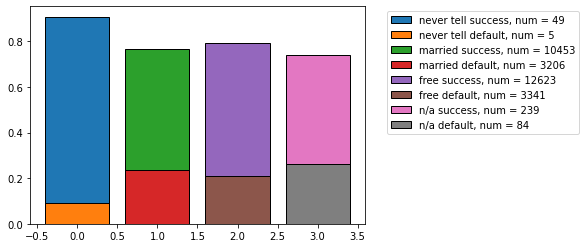

In [165]:
_, ax = plt.subplots(facecolor='w')
barPlot_contingency(marriage_contingency_matrix, 
                    ['never tell','married','free','n/a'], ['success', 'default'], ax)

Глядя на данный график кажется, что доля тех, что доля тех, кто умалчивает о своем семейном положении и невыплачивает кредит, меньше остальных. Однако в данной группе очень мало примеров относительно остальных, поэтому нельзя делать таких поспешных выводов.

Как говорилось выше будем использовать критерий Хи-квадрат.Проверим корректность использования этого критерия:

In [170]:
marriage_contingency_matrix_to_vec = marriage_contingency_matrix.reshape(-1)
mar_to_vec_is_enough = len(list(filter(lambda val: val > 5, marriage_contingency_matrix_to_vec)))
mar_all_to_vec_count = len(marriage_contingency_matrix_to_vec)
mar_elements_count = sum(marriage_contingency_matrix_to_vec)
print('Общее количество элементов: %i.\nПроцент ячеек, где количество элементов больше 5: %.4f%%' % 
      (mar_elements_count, (float(mar_to_vec_is_enough) * 100 / mar_all_to_vec_count)))

Общее количество элементов: 30000.
Процент ячеек, где количество элементов больше 5: 87.5000%


Применение критерия Хи-квадрат корректно.

In [171]:
stat_val, p_val = v_Cramer_correlation(marriage_contingency_matrix)
print('V-Cramer statistic is: %.4f' % stat_val)
print('p-value:', p_val)

V-Cramer statistic is: 0.0345
p-value: 8.825862457577375e-08


Достигаемый уровень p-value критерия хи-квадрат позволяет отклонить гипотезу об отсутсвии взаимосвязи, однако значение коэффициента V Крамера не очень велико, поэтому и из видуального анализа можно заключить, что значение признака 'MARRIAGE' не сильно влияет на возврат долга.

#Задание 5

Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   

a)  о равенстве медианных значений возрастов людей   

b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  

Значимы ли полученные результаты с практической точки зрения ?

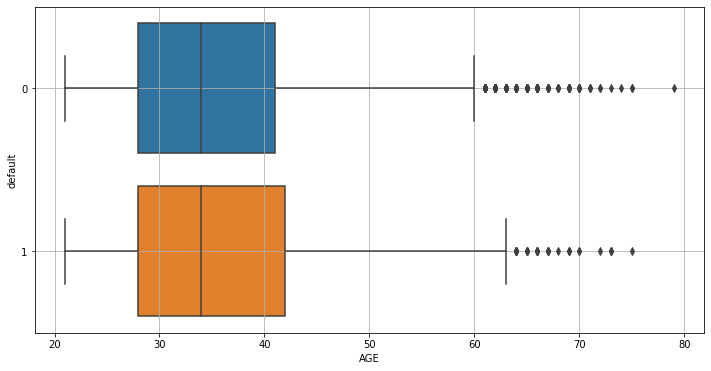

In [172]:
_, ax = plt.subplots(figsize = (12, 6), facecolor='w')
sns.boxplot(y='default', x='AGE', data=df, orient="h", ax=ax)
ax.grid()

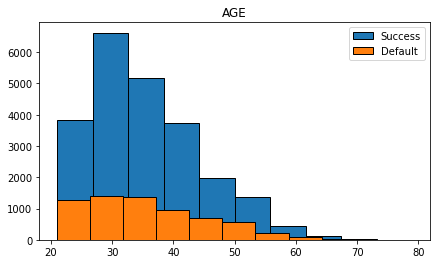

In [173]:
_, ax = plt.subplots(figsize = (7, 4), facecolor='w')
df_success.hist(column='AGE', label='Success', ax=ax, ec='k')
df_default.hist(column='AGE', label='Default', ax=ax, ec='k')
ax.legend()
ax.grid(False)
plt.show()

По виду boxplot и гистограмм медианы качествено не различиются. Но проверим это более формально.

In [177]:
# confint for default data median
med_default_ages_confint = calculate_median_confidence_interval(df_default['AGE'].values, 
                                                                samples_count, alpha)
# confint for success data median
med_success_ages_confint = calculate_median_confidence_interval(df_success['AGE'].values, 
                                                                samples_count, alpha)
# confint for difference midle default and success data median
med_delta_ages_confint = compare_distributions(df_success['AGE'].values, 
                                              df_default['AGE'].values, 
                                              samples_count, alpha)

In [178]:
print('median for default ages: %.4f\tconf_int: %s' % med_default_ages_confint)
print('median for success ages: %.4f\tconf_int: %s' % med_success_ages_confint)
print('conf_int for difference between ages in default & success groups is %s' % med_delta_ages_confint)

median for default ages: 34.0000	conf_int: [34. 35.]
median for success ages: 34.0000	conf_int: [34. 34.]
conf_int for difference between ages in default & success groups is [-1.  0.]


Как и раньше используем перестановочный критерий для двух независимых выборок:


In [180]:
print('Permutation criterion p-value: %.4f' % permutation_test(df_default['AGE'].values, 
                                                               df_success['AGE'].values, 
                                                               max_permutations=1000, 
                                                               alternative='two-sided'))

Permutation criterion p-value: 1.0000


При полученном значении p-value в перестановочном критерии мы не можем отвергнуть нулевую гипотезу о равенстве медиан признака 'AGE' для вернувших и просрочивших кредит.

# ИТОГ
В ходе анализа было получено, что  

* размер кредитного лимита для людей, не допускающих просрочки по кредиту, значимо выше.
* гендерный состав людей вернувших и просрочивших долг значимо различается, а именно доля женщин, не допускающих просрочку, выше.
* образование не сильно, но все-таки статистически значимо влияет на вероятность возврата долга.
* возрастной состав в группах вернувших и просрочивших долг примерно одинаков.